# 04 — Diagnóstico de los Folds de Validación Cruzada

**Objetivo:** Verificar visual y estadísticamente que nuestra estrategia de validación cruzada estratificada para regresión funciona correctamente. El objetivo es confirmar que la distribución de la variable objetivo es similar en cada uno de los folds de validación.

**Entradas:**
- `data/feast/training_set.parquet`: El dataset de entrenamiento final generado por Feast.
- `src/splits.py`: La función `stratified_regression_folds`.

**Salidas:**
- **Gráfico de Densidad:** Una visualización que compara la distribución de `log1p(target)` para cada fold. Esperamos que las curvas se superpongan en gran medida.
- **Tabla de Estadísticas:** Un resumen numérico que muestra el tamaño, la media, la desviación estándar y los rangos del target para cada fold. Esperamos que estos valores sean muy similares.

**Dependencias:**
- Requiere haber ejecutado el pipeline de DVC al menos hasta el `stage` `feast_build` (`dvc repro feast_build`).

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from src.config import FEAST_TRAINSET, TARGET
from src.splits import stratified_regression_folds

2025-08-24 11:20:05.346 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops


In [2]:
df = pd.read_parquet('../' + FEAST_TRAINSET)  # generado por 03 / scripts/build_training_set.py
y  = df[TARGET].copy()
folds = stratified_regression_folds(y, n_splits=5, seed=42)
# len(folds), y.shape

/home/fernando/Documentos/insurance-mlops/.venv/lib/python3.11/site-packages/pandas/core/arrays/base.py:725: RuntimeWarning: invalid value encountered in cast
  return np.array(self, dtype=dtype, copy=copy)


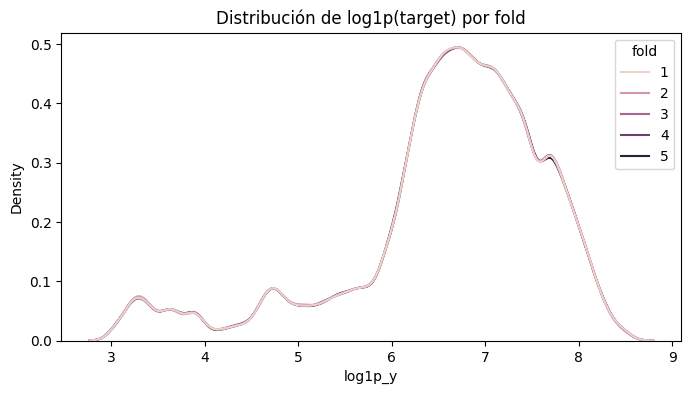

In [3]:
import seaborn as sns
yb = np.log1p(y)
assign = np.zeros(len(y), dtype=int)
for i, (_, va) in enumerate(folds, 1): assign[va] = i
tmp = pd.DataFrame({"log1p_y": yb, "fold": assign})
plt.figure(figsize=(8,4))
sns.kdeplot(data=tmp, x="log1p_y", hue="fold", common_norm=False)
plt.title("Distribución de log1p(target) por fold");

In [4]:
rows=[]
for i,(_,va) in enumerate(folds,1):
    yt = y.iloc[va]
    rows.append({"fold": i, "n": yt.size, "mean": yt.mean(), "std": yt.std(), "min": yt.min(), "max": yt.max()})
pd.DataFrame(rows)

,fold,n,mean,std,min,max
0,1,240000,1102.815500,865.360118,20.0,4992.0
1,2,240000,1103.089442,866.524554,20.0,4996.0
2,3,240000,1101.723512,862.946878,20.0,4997.0
3,4,240000,1102.565708,864.952403,20.0,4999.0
4,5,240000,1102.529946,865.213063,20.0,4994.0
